### Checkpoint 6

In [96]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import time
from scipy import integrate
import scipy
import scipy.stats

In [97]:
from iminuit import Minuit

In [32]:
DATA = np.loadtxt('exp.txt')

### Part 1

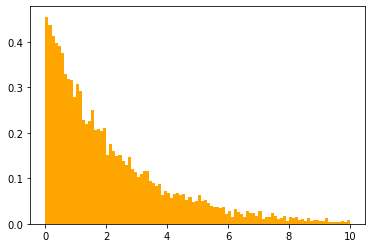

In [287]:
#print histogram of 10,000 decay times, in 100 bins
#normalize the histogram with density=True
N, bins, _ = plt.hist(DATA,bins=100,density=True,color='orange')
plt.show()

In [288]:
#Implement a maximum likelihood fit to these data to determine the lifetime and its error

In [331]:
#define exponential decay function which is normalized between 0 and 10
def func1(t,tau):
    xmin=0
    xmax=10
    return np.exp(-t/tau) * 1/(tau*(np.exp(-xmin/tau) -  np.exp(-xmax/tau)))

#### Using SCIPY.MINIMIZE

In [332]:
#define a negative log likelihood function
def NLL(args, func, data):
    """Negative log likelihood"""
    #sum of (log(function))
    return - np.sum(np.log(func(data, *args)))

In [333]:
#minimize the negative log likelihood using scipy, give x0 a guess that isnt the exact answer, so it keeps finding optimal value
#i.e. set tau = 1
result = scipy.optimize.minimize(NLL, args = (func1, DATA), x0 = 1, method = "L-BFGS-B")

In [334]:
#the tau guess is given by res.x
tau_guess = result.x
#the errors are calculated by the hess matrix
HESS_INV = scipy.optimize.minimize(NLL,args=(func1,DATA),x0=1).hess_inv
#from documentation: '.hess_inv' returned by the fit is the covariance matrix describing the Gaussian approximation of LL
#the parameter errors are the root of the diag elements of hess_inv
errs = np.sqrt(np.diag(HESS_INV))

In [335]:
#tau is given as 2.204 microseconds, close to the true value of 2.2
tau_guess, errs 

(array([2.20434418]), array([0.02502716]))

### Using Miniut

In [361]:
def get_NLL(tau): 
    xmin = 0
    xmax = 10
    #generate the mean, mu, by calculating rate equation for the different times in dataset
    mu = func1(DATA,tau) 
    #generate the log using the calculated mean
    LL = np.log(mu)
    #negative log likely hood is the negative of the sum over all log values
    NLL = -np.sum(LL)
    return NLL

In [377]:
get_NLL.errordef = Minuit.LIKELIHOOD #this is 0.5 
#use the Minuit module, guess again for tau=1
m = Minuit(get_NLL, tau = 1.)

In [378]:
#minimization given by minuit
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.731e+04                  │              Nfcn = 29               │
│ EDM = 1.06e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau  │   2.204   │   0.025   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────────┐
│     │      tau │
├─────┼──────────┤
│ tau │ 0.000627 │
└─────┴──────────┘

In [364]:
#print the errors given by minuit
print(m.errors)

<ErrorView tau=0.025042335479675486>


In [365]:
#generate function with parametrs given by minuit
t = np.linspace(0,10,1000)
y1 = func1(t, 2.204)

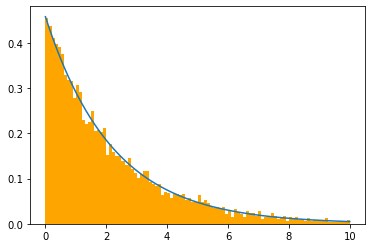

In [366]:
#overlay plot of function given by minuit and the histogram of real data
plt.plot(t,y1)
N, bins, _ = plt.hist(DATA,bins=100,density=True,color='orange')
plt.show()

### Part 2

In [367]:
DATA2 = np.loadtxt('expresonance.txt')

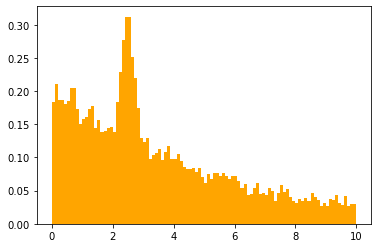

In [368]:
#print histogram of decay times including background and signal, in 100 bins
#normalize the histogram with density=True
N, bins, _ = plt.hist(DATA2,bins=100,density=True,color='orange')
plt.show()

In [369]:
from scipy import integrate

In [370]:
def func2(t, lifetime, gauss_mu, frac):
    
    xmin = 0
    xmax = 10
    #width of gauss signal
    sigma = 0.2

    #background given as normalized exponential decay
    BKG = np.exp(-t/lifetime) * 1/(lifetime*(np.exp(-xmin/lifetime) -  np.exp(-xmax/lifetime)))
    #signal given as normalised gaussian with mean 'gauss_mu' and standard deviation 'sigma'
    GAUSS = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(t-gauss_mu)**2/sigma**2)
    
    #returns composite function fraction of background + (1-fraction) of signal
    return frac*BKG + (1-frac)*GAUSS

In [371]:
def get_NLL2(lifetime, gauss_mu, frac): 
    xmin = 0
    xmax = 10
    #generate the mean, mu
    mu = func2(DATA2, lifetime, gauss_mu, frac)
    #make sure that if mean is less than 10-4, return 10-4, so that there are no negative errors
    mu[mu<1e-4] = 1e-4
    #generate the log using the calculated mean
    LL = np.log(mu)
    #negative log likely hood is the negative of the sum over all log pmfs
    NLL = -np.sum(LL)
    return NLL

In [372]:
#set error of NLL to 0.5
get_NLL2.errordef = Minuit.LIKELIHOOD
#give guesses for lifetime, gaussian mean and fraction
m = Minuit(get_NLL2, lifetime = 3.0, gauss_mu = 2.5, frac = 0.8)

In [373]:
#get minimizer
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.102e+04                  │              Nfcn = 88               │
│ EDM = 3.97e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lifetime │   5.04    │   0.10    │            │            │         │         │       │
│ 1 │ gauss_mu │   2.500   │   0.012   │            │            │         │         │       │
│ 2 │ frac     │   0.903   │   0.005   │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────┐
│          │  lifetime  gauss_mu      frac │
├──────────┼───────────────────────────────┤
│ lifetime │    0.0105 -4.18e-05 -4.49e-05 │
│ gauss_mu │ -4.18e-05  0.000139  8.43e-07 │
│     frac │ -4.49e-05  8.43e-07  2.03e-05 │
└──────────┴───────────────────────────────┘

In [374]:
#generate function with parametrs given by minuit
t = np.linspace(0,10,1000)
y = func2(t, 5.04, 2.500, 0.903)

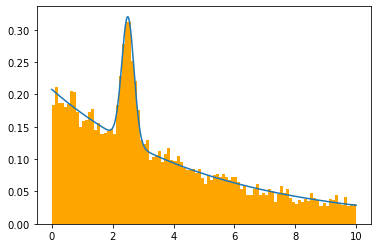

In [375]:
#overlay plot of function given by minuit and the histogram of real data
plt.plot(t,y)
plt.hist(DATA2,bins=100,density=True,color='orange')
plt.show()

In [376]:
#print the errors given by minuit
m.errors

<ErrorView lifetime=0.10269588580422455 gauss_mu=0.011786586701152822 frac=0.004506502513652584>